In [84]:

import pandas as pd
import dotenv
import os
from typing import Literal
import numpy as np
dotenv.load_dotenv()

True

Control Panel

In [85]:
# Pull price data from db for this ticker
symbol = 'SPY'

In [86]:
# with pandas, select * from enhanced_price_table from NEONDB where symbol = symbol
neon_db_url = os.environ.get("NEON_DB_CONSTR")
stock_data = pd.read_sql(
    f'select * from stock_data '
    f'where stock_data.symbol = \'{symbol}\' '
    f'order by stock_data.bar_number asc', con=neon_db_url
)
regime_data = pd.read_sql(f'select * '
                          f'from regime '
                          f'where regime.symbol = \'{symbol}\'', con=neon_db_url)
peak_data = pd.read_sql(f'select '
                        f'* from peak '
                        f'where peak.symbol = \'{symbol}\'', con=neon_db_url)


In [87]:
def retest_swing(
        swings: pd.DataFrame,
        base_swing: pd.Series,
        price_data: pd.DataFrame,
        sign_filter: Literal[1, -1],
        retest_swing_lvl: Literal[1, 2],
):
    """
    Find the latest retest swing after a given base swing
    Used to detect trend exhaustion. Tries to predict the next swing faster than classic swing detection (

    The new swing is the row at the largest distance from the major swing which is followed by a failed retest of the major swing, followed price breaching the failed retest.

    :param base_swing:
    :param price_data:
    :param swings: all swings for a given symbol,
    :param sign_filter: filter swings by sign
    :param retest_swing_lvl:
    :return: a new swing row where retest criteria is met
    """
    sign_swings = swings.loc[
        (swings['type'] == sign_filter)
    ].copy()

    retest_price_segment = price_data.loc[base_swing['end']:, 'close']
    # calc cummax/cummin of retest_price_segment
    extreme_price_idx = getattr(retest_price_segment, 'idxmax' if sign_filter == 1 else 'idxmin')()
    # filter for retest swings that occur after extreme_price_idx
    retest_swings = sign_swings.loc[
        (sign_swings['lvl'] == retest_swing_lvl) &
        (sign_swings['start'] > extreme_price_idx)
    ].copy()
    if not retest_swings.empty:
        # select the row in retest_swings with the highest en_px if sign_filter == 1, else the lowest
        retest_swing = retest_swings.loc[
            retest_swings['en_px'].idxmax() if sign_filter == 1 else retest_swings['en_px'].idxmin()
        ]
        retest_price_segment = retest_price_segment.loc[retest_swing['end']:]
        # get the close idx that breaches the swing low or swing high, if ever
        test_values = getattr(
            retest_price_segment,
            'cummin' if sign_filter == 1 else 'cummax'
        )()
        breach_test = np.sign((retest_swing.en_px - test_values) * sign_filter) == 1
        swing_detected = None
        if breach_test.any():
            breach_data = test_values.loc[breach_test]
            breach_idx = breach_data.index[0]
            breach_price = breach_data.iloc[0]
            swing_detected = pd.Series({
                'start': extreme_price_idx,
                'end': breach_idx,
                'type': -sign_filter,
                'lvl': base_swing['lvl'],
                'st_px': price_data.loc[extreme_price_idx, 'close'],
                'en_px': breach_price,
                'symbol': retest_swing.symbol,
                'is_relative': retest_swing.is_relative
            })
        return swing_detected

def retest_from_latest_base_swing(
        swings: pd.DataFrame,
        price_data: pd.DataFrame,
        sign_filter: Literal[1, -1],
        retest_swing_lvl: Literal[1, 2],
        base_swing_lvl: Literal[2, 3],
):
    """
    Find the latest base swing and then find the latest retest swing after that base swing
    :param swings:
    :param price_data:
    :param sign_filter:
    :param retest_swing_lvl:
    :param base_swing_lvl:
    :return:
    """
    assert retest_swing_lvl < base_swing_lvl, 'retest_swing_lvl must be less than base_swing_lvl'
    # get the latest base swing
    base_swings = swings.loc[
        (swings['lvl'] == base_swing_lvl) &
        (swings['type'] == sign_filter)
    ]
    discover_swing = None
    if not base_swings.empty:
        base_swing = base_swings.iloc[-1]
        discover_swing = retest_swing(
            swings=swings,
            base_swing=base_swing,
            price_data=price_data,
            sign_filter=sign_filter,
            retest_swing_lvl=retest_swing_lvl
        )
    return discover_swing


def find_all_retest_swing(
        swings: pd.DataFrame,
        base_swing: pd.Series,
        price_data: pd.DataFrame,
        sign_filter: Literal[1, -1],
        retest_swing_lvl: Literal[1, 2],
):
    """
    Find all retest swings after the latest base swing
    :param base_swing:
    :param swings:
    :param price_data:
    :param sign_filter:
    :param retest_swing_lvl:
    :param base_swing_lvl:
    :return:
    """
    # get all retest swings after the latest base swing
    retest_swings = swings.loc[
        (swings.start > base_swing.end) &
        (swings['lvl'] == retest_swing_lvl) &
        (swings['type'] == sign_filter)
    ].copy()
    # sort swings by start
    retest_swings = retest_swings.sort_values(by='start').reset_index(drop=True)
    # get cummax of st_px if sign_filter == 1, else cummin
    extreme_price = getattr(retest_swings.st_px, 'cummax' if sign_filter == 1 else 'cummin')()
    retest_swings = retest_swings.loc[retest_swings.st_px == extreme_price].reset_index(drop=True)
    # for each retest swing, get the price segment from the base swing end to the retest swing end
    # iterate over retest_swings
    predicted_swings = []
    for idx, data in retest_swings.iterrows():
        # limit scope of the price segment to discover previous cases
        # where retest swing was found
        try:
            # limit search to the min/max value found between the current and next retest swing
            # to find genuine retest swings
            next_retest_idx = retest_swings.loc[idx + 1, 'start']
        except KeyError:
            next_retest_idx = len(price_data)
        finally:
            price_boundary_idx = getattr(
                price_data.loc[data.start:next_retest_idx, 'close'],
                'idxmin' if sign_filter == 1 else 'idxmax'
            )()
        price_segment = price_data.loc[:price_boundary_idx].copy()
        discovered_swing = retest_swing(
            swings=swings,
            base_swing=base_swing,
            price_data=price_segment,
            sign_filter=sign_filter,
            retest_swing_lvl=retest_swing_lvl,
        )
        if discovered_swing is not None:
            predicted_swings.append(discovered_swing)

    discovered_retest_swings = pd.DataFrame(predicted_swings)
    discovered_retest_swings['lvl'] = base_swing.lvl
    return discovered_retest_swings



abs_swing_retest = retest_from_latest_base_swing(
    swings=peak_data.loc[peak_data['is_relative'] == False],
    price_data=stock_data.loc[stock_data['is_relative'] == False],
    sign_filter=regime_data.rg.iloc[-1],
    retest_swing_lvl=1,
    base_swing_lvl=3
)

_base_swing = peak_data.loc[
    (peak_data['is_relative'] == False) &
    (peak_data['lvl'] == 3) &
    (peak_data['type'] == regime_data.rg.iloc[-1])
].iloc[-1]

all_retest_swings = find_all_retest_swing(
    base_swing=_base_swing,
    swings=peak_data.loc[peak_data['is_relative'] == False],
    price_data=stock_data.loc[stock_data['is_relative'] == False],
    sign_filter=regime_data.rg.iloc[-1],
    retest_swing_lvl=1,
)
# add abs_swing_retest to peak_data
peak_data = pd.concat([peak_data, all_retest_swings], ignore_index=True)

In [88]:


from copy import copy


def add_peak_regime_data(_price_data, _regime_data, _peak_data):
    # for each unique regime_data.type, create a column in stock_data named after type. set the value of rg in regime_data of stock_data indexes from regime_data.start to regime_data.end
    # TODO implement this function for fc tables object
    _price_data = _price_data.copy()
    for index, row in _regime_data.iterrows():
        _price_data.loc[row.start:row.end, row.type] = row.rg

    for index, row in _peak_data.iterrows():
        peak_lvl = row['lvl']
        peak_col = f'lo{peak_lvl}' if row['type'] == 1 else f'hi{peak_lvl}'
        _price_data.loc[row.start, peak_col] = row.st_px
        _price_data.loc[row.end, 'd'+peak_col] = row.en_px

    return _price_data

# plot stock_data close, lo3 as green up arrow, hi3 as red down arrow. rg, sma, and bo plotted on second y axis
def plot(_stock_data, title):
    style_map = {
        'close': '-',
        'lo3': 'g^',
        'dlo3': 'k^',
        'hi3': 'rv',
        'dhi3': 'kv',
        'lo2': 'g.',
        'dlo2': 'k.',
        'hi2': 'r.',
        'dhi2': 'm.',
        'fc': 'b--',
        'sma': 'y--',
        'bo': 'k--',
        'tt': 'c--'
    }
    remove_keys = []
    for key, val in style_map.items():
        if key not in _stock_data.columns:
            remove_keys.append(key)
    for key in remove_keys:
        style_map.pop(key)
    secondary_y = ['fc', 'sma', 'bo', 'tt']
    try:
        _stock_data[
            style_map.keys()].plot(style=list(style_map.values()), secondary_y=secondary_y, figsize=(15, 10), title=title)
    except KeyError:
        pass


In [89]:
relative_stock_data = add_peak_regime_data(
    stock_data.loc[stock_data.is_relative == True].reset_index(drop=True),
    regime_data.loc[regime_data.is_relative == True].reset_index(drop=True),
    peak_data.loc[peak_data.is_relative == True].reset_index(drop=True)
)
absolute_stock_data = add_peak_regime_data(
    stock_data.loc[stock_data.is_relative == False].reset_index(drop=True),
    regime_data.loc[regime_data.is_relative == False].reset_index(drop=True),
    peak_data.loc[peak_data.is_relative == False].reset_index(drop=True)
)

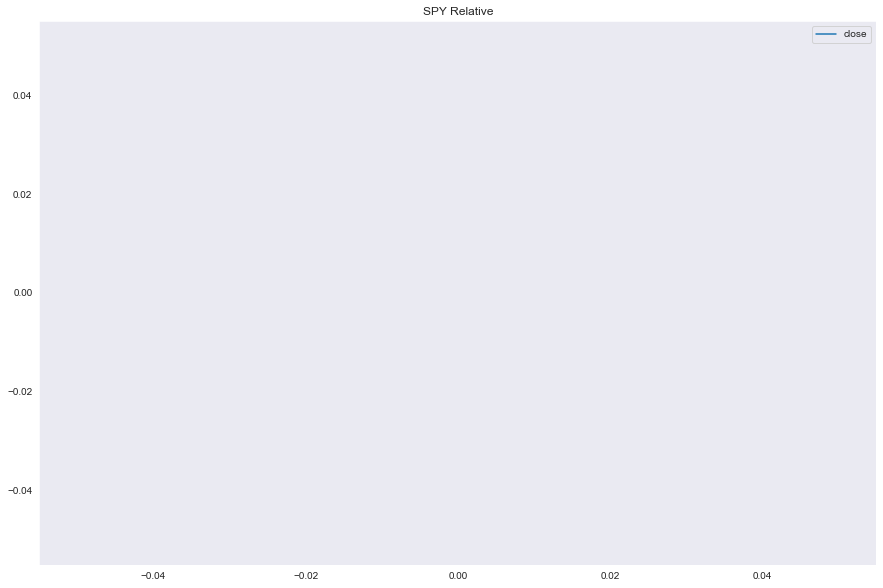

In [90]:
plot(relative_stock_data, f'{symbol} Relative')

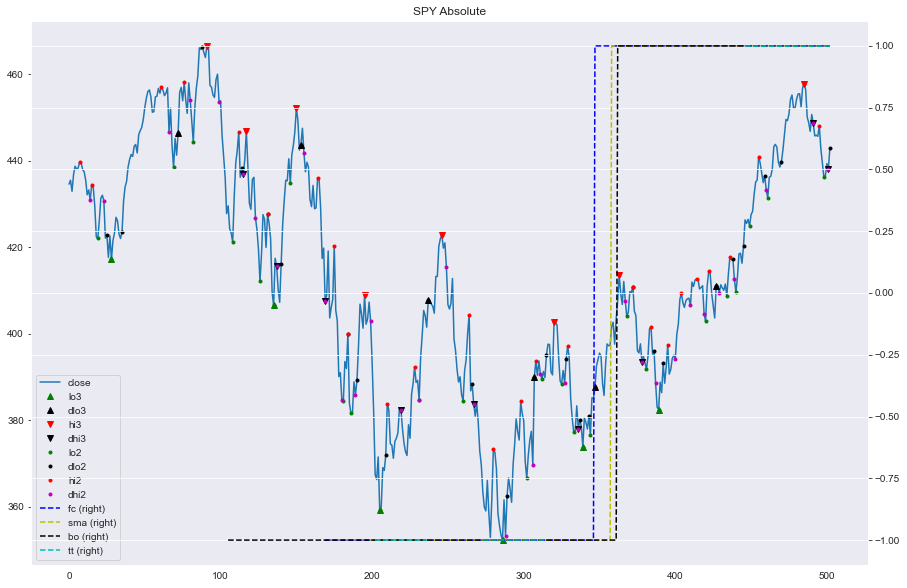

In [91]:
plot(absolute_stock_data, f'{symbol} Absolute')

<AxesSubplot:title={'center':'SPY Absolute Close'}>

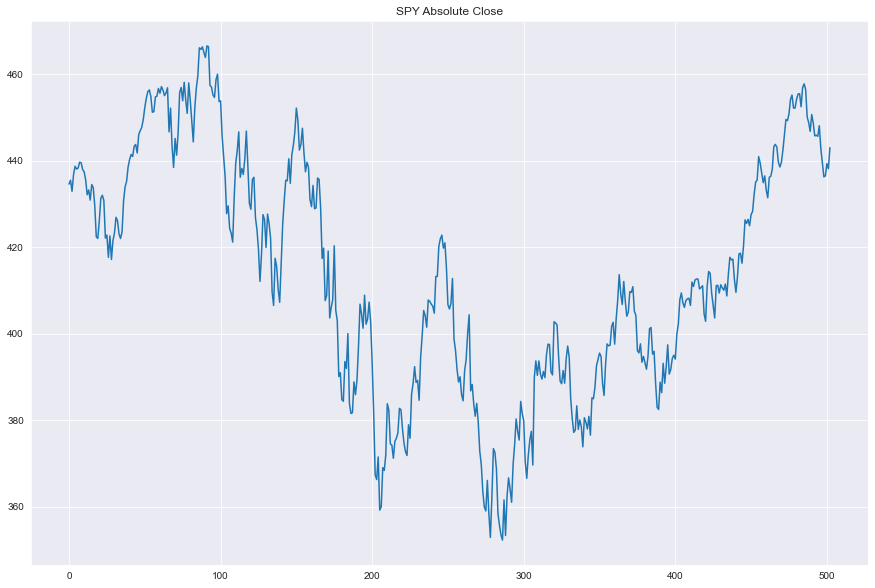

In [92]:
# plot absolute close price
absolute_stock_data.close.plot(figsize=(15, 10), title=f'{symbol} Absolute Close')